## Project Part 2: Swaption Calibration

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
import matplotlib.pyplot as plt

import datetime as dt
import yfinance as yf

import plotly.graph_objects as go

## Pricing Swaption

We note that the pricing of swaption is using the PVBP as the numeraire, represented by portfolio of traded assets which has strictly positive value. The payoff for the waption will be the same as the vanilla option, hence the formula used is identical when pricing for the vanilla.

For payer swaption, the corresponding payoff and option value will be:
$$
P_{n+1,N}(T)(S_{n+1,N} - K)^+
$$

$$
V^{payer}_{n,\  N}\left( 0\right)  =P_{n+1,N}\left( 0\right)  E^{n+1,N}\left[ S_{n,N}\left( 0\right)  \Phi \left( d_{1}\right)  -K\Phi \left( d_{2}\right)  \right]  
$$

For receiver swaption value:
$$
P_{n+1,N}(T)(K - S_{n+1,N})^+
$$

$$
V^{rec}_{n,\  N}\left( 0\right)  =P_{n+1,N}\left( 0\right)  E^{n+1,N}\left[ K\Phi \left( -d_{2}\right)  -S_{n,N}\left( 0\right)\Phi \left( -d_{1}\right)  \right]  
$$

### Part 1: Data Collection

In [119]:
swaption_data = pd.read_excel("IR Data.xlsx", sheet_name ='Swaption')
swaption_data.columns = swaption_data.iloc[1]
swaption_data = swaption_data.dropna().drop(index=1).reset_index(drop=True)
swaption_data['Tenor'] = swaption_data['Tenor'].str.strip().str.lower().str.replace('y', '', regex=False).astype(int)
swaption_data['Expiry'] = swaption_data['Expiry'].str.strip().str.lower().str.replace('y', '', regex=False).astype(int)
swaption_data.iloc[:, 2:] = swaption_data.iloc[:, 2:] / 100

swaption_data

1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.9157,0.6203,0.4413,0.31224,0.26182,0.225,0.2096,0.214,0.2434,0.27488,0.30297
1,1,2,0.8327,0.6124,0.4657,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523
2,1,3,0.7392,0.5687,0.4477,0.35745,0.32317,0.2978,0.2829,0.278,0.2877,0.30725,0.32833
3,1,5,0.5519,0.4464,0.3651,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165
4,1,10,0.4118,0.3504,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355
5,5,1,0.678,0.4909,0.384,0.31485,0.2906,0.2726,0.2604,0.2532,0.2494,0.2532,0.2598
6,5,2,0.5788,0.4641,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.2654,0.2676
7,5,3,0.5343,0.4444,0.3818,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.262,0.2615
8,5,5,0.4199,0.36524,0.32326,0.29005,0.27677,0.266,0.2573,0.2502,0.2406,0.2357,0.234
9,5,10,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.2249,0.2225


In [338]:
# Obtain data for the forward swap rate
forward_rate = pd.read_excel('Forward Swap Rate.xlsx', index_col=0)
forward_rate = forward_rate.reset_index()

# Reformatting the forward rate format
forward_rate = forward_rate.melt(id_vars='Expiry', var_name='Tenor', value_name='Rate')

def convert_to_years(x):
    return int(x[:-1])

forward_rate['Expiry'] = forward_rate['Expiry'].apply(convert_to_years)
forward_rate['Tenor'] = forward_rate['Tenor'].apply(convert_to_years)
forward_rate = forward_rate.sort_values(by=['Expiry', 'Tenor']).reset_index()
forward_rate = forward_rate.drop(columns=['index'])
forward_rate

,Expiry,Tenor,Rate
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038428
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634


In [340]:
## Obtain data for discount factor
discount_rate = pd.read_excel('IRS_data.xlsx')
discount_rate

,Unnamed: 0,Tenor,Rate,OIS_DF,LIBOR_DF
0,0,0.5,0.025000,0.998752,0.987654
1,1,1.0,0.028000,0.997009,0.972577
2,2,1.5,0.029000,0.995270,0.957378
3,3,2.0,0.030000,0.993531,0.942179
4,4,2.5,0.030750,0.991773,0.926330
5,5,3.0,0.031500,0.990015,0.910482
6,6,3.5,0.032000,0.988066,0.894731
7,7,4.0,0.032500,0.986117,0.878981
8,8,4.5,0.032750,0.984150,0.863985
9,9,5.0,0.033000,0.982184,0.848989


In [342]:
# Calculate the strike of the swap (using the forward swap rates data from Part 1 + shift)

shift = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] # bps in percentage form
swap_strike = [[item + s for s in shift] for item in forward_rate['Rate']]
strike_values_df = pd.DataFrame(swap_strike, columns=swaption_data.columns[2:13])

# Combine with expiry and tenor swap data columns
strike_df = pd.concat([swaption_data[['Expiry', 'Tenor']], strike_values_df], axis=1)
strike_df

1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.012007,0.017007,0.022007,0.027007,0.029507,0.032007,0.034507,0.037007,0.042007,0.047007,0.052007
1,1,2,0.013259,0.018259,0.023259,0.028259,0.030759,0.033259,0.035759,0.038259,0.043259,0.048259,0.053259
2,1,3,0.014011,0.019011,0.024011,0.029011,0.031511,0.034011,0.036511,0.039011,0.044011,0.049011,0.054011
3,1,5,0.015255,0.020255,0.025255,0.030255,0.032755,0.035255,0.037755,0.040255,0.045255,0.050255,0.055255
4,1,10,0.018428,0.023428,0.028428,0.033428,0.035928,0.038428,0.040928,0.043428,0.048428,0.053428,0.058428
5,5,1,0.019274,0.024274,0.029274,0.034274,0.036774,0.039274,0.041774,0.044274,0.049274,0.054274,0.059274
6,5,2,0.020075,0.025075,0.030075,0.035075,0.037575,0.040075,0.042575,0.045075,0.050075,0.055075,0.060075
7,5,3,0.020072,0.025072,0.030072,0.035072,0.037572,0.040072,0.042572,0.045072,0.050072,0.055072,0.060072
8,5,5,0.021093,0.026093,0.031093,0.036093,0.038593,0.041093,0.043593,0.046093,0.051093,0.056093,0.061093
9,5,10,0.023634,0.028634,0.033634,0.038634,0.041134,0.043634,0.046134,0.048634,0.053634,0.058634,0.063634


### Part 2: Model Calibration : Displaced Diffusion Model

If the observed market implied volatility skew is between normal and log normal, we can use displaced diffusion model as the extension from the Black Scholes model to price the swaption, with price as below:
$$
V_{n,\  N}\left( 0\right)  =P_{n+1,N}\left( 0\right)  Black76\left( \frac{S_{n,N}\left( 0\right)  }{\beta } ,\  K+\frac{1-\beta }{\beta } S_{n,N}\left( 0\right)  ,\  \sigma \beta ,\  T\right)  
$$

#### 2a: Black76 Model Option Pricing

In [347]:
def Black76Call(S, K, sigma, T, disc_factor):
    d1 = (np.log(S / K)+ (sigma**2) / 2 * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return disc_factor * (S * norm.cdf(d1) - K * norm.cdf(d2))

def Black76Put(S, K, sigma, T, disc_factor):
    d1 = (np.log(S / K)+ (sigma**2) / 2 * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return disc_factor * (K * norm.cdf(-d2) - S * norm.cdf(-d1))

def ImpliedCallVolBS(S, K, price, T, disc_factor):
    impliedVol = brentq(lambda x: price - 
                        Black76Call(S, K, x, T, disc_factor),
                        1e-6, 10)

    return impliedVol

def ImpliedPutVolBS(S, K, price, T, disc_factor):
    impliedVol = brentq(lambda x: price - 
                        Black76Put(S, K, x, T, disc_factor),
                        1e-6, 10)

    return impliedVol

#### 2b: Displaced Diffusion Model Swaption Pricing

In [350]:
# Calculate the displaced diffusion swaption pricing
def DisplacedDiffusionPayer(F, K, T, disc_factor, sigma, beta):
    adj_F = F / beta
    adj_K = K + ((1 - beta) / beta) * F
    adj_sigma = sigma * beta
    d1 = (np.log(adj_F / adj_K)+ ((adj_sigma**2) / 2) * T)  / (adj_sigma * np.sqrt(T))
    d2 = d1 - adj_sigma * np.sqrt(T)
    return disc_factor * (adj_F * norm.cdf(d1) - adj_K * norm.cdf(d2))

def DisplacedDiffusionReceiver(F, K, T, disc_factor, sigma, beta):
    adj_F = F / beta
    adj_K = K + ((1 - beta) / beta) * F
    adj_sigma = sigma * beta
    d1 = (np.log(adj_F / adj_K)+ ((adj_sigma**2) / 2) * T)  / (adj_sigma * np.sqrt(T))
    d2 = d1 - adj_sigma * np.sqrt(T)
    return disc_factor * (adj_K * norm.cdf(-d2) - adj_F * norm.cdf(-d1))

In [352]:
# Model the calibration function (start using the payer swap as the base case)
# Holding the put parity relationship, the receiver swaption could be value from vanilla option and the the payer swaption

def DisplacedDiffusionCalib(x, S, strikes, disc_factor, vols, T):
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffusionPayer(S, strikes[i], T, disc_factor, x[0], x[1])
        err += (vol - ImpliedCallVolBS(S, strikes[i], price, T, disc_factor)) ** 2
    return err

#### 2c: Calculate the Displaced Diffusion Parameter Calibration

In [355]:
# Calculate the PVBP as numeraire

pvbp_list = []
for i in range(len(swaption_data)):
    begin = swaption_data['Expiry'][i]
    end = swaption_data['Tenor'][i]

    # Given the swaption has cashflow of semiannual payment (0.5 time spacing, so we multiply with 2 for index)
    start_idx = int(begin * 2)
    end_idx = int((begin + end) * 2)
    
    df_slice = discount_rate['OIS_DF'].iloc[start_idx:end_idx]
    pvbp = 0.5 * df_slice.sum()

    pvbp_list.append(pvbp)

In [363]:
dd_model_df = pd.concat([swaption_data[['Expiry','Tenor']], 
                         swaption_data['ATM']], axis=1)
dd_model_df['Forward Rate'] = forward_rate['Rate']
dd_model_df['PVBP'] = pvbp_list
dd_model_df

,Expiry,Tenor,ATM,Forward Rate,PVBP
0,1,1,0.225,0.032007,0.994400
1,1,2,0.2872,0.033259,1.985294
2,1,3,0.2978,0.034011,2.972386
3,1,5,0.2607,0.035255,4.934070
4,1,10,0.2447,0.038428,9.747887
5,5,1,0.2726,0.039274,0.978517
6,5,2,0.2983,0.040075,1.952145
7,5,3,0.2998,0.040072,2.920444
8,5,5,0.266,0.041093,4.840612
9,5,10,0.2451,0.043634,9.542492


In [365]:
# Find the calibration for sigma and beta in each swaption case (using least square estimation)
# For each row in expiry and tenor of swaption
dd_calib_data = swaption_data.copy()
initialGuess = [0.1, 0.1]
dd_calib_sigma = np.zeros(len(swaption_data))
dd_calib_beta = np.zeros(len(swaption_data))

for i in range(len(swaption_data)):
    swap_rate = dd_model_df['Forward Rate'].iloc[i]
    strike = strike_df.iloc[i, 2:]
    disc_factor = dd_model_df['PVBP'].iloc[i]
    market_iv = swaption_data.iloc[i, 2:]
    maturity = swaption_data.iloc[i, 0]

    res = least_squares(lambda x: DisplacedDiffusionCalib(x, 
                                                          swap_rate, 
                                                          strike, 
                                                          disc_factor, 
                                                          market_iv, 
                                                          maturity),
                        initialGuess, bounds = ((0, 0), (np.inf, 1)))
    
    dd_calib_sigma[i] = res.x[0]
    dd_calib_beta[i] = res.x[1]

    for j in range(len(swaption_data.columns)-2):
        strike = strike_df.iloc[i, j+2]
        atm_strike = strike_df['ATM'].iloc[i, ]

        if strike <= atm_strike:
            dd_receiver = DisplacedDiffusionReceiver(swap_rate, strike, maturity, disc_factor, dd_calib_sigma[i], dd_calib_beta[i])
            dd_vol = ImpliedPutVolBS(swap_rate, strike, dd_receiver, maturity, disc_factor)

        elif strike > atm_strike:
            dd_payer = DisplacedDiffusionPayer(swap_rate, strike, maturity, disc_factor, dd_calib_sigma[i], dd_calib_beta[i])
            dd_vol = ImpliedCallVolBS(swap_rate, strike, dd_payer, maturity, disc_factor)

        dd_calib_data.iloc[i, j+2] = dd_vol

dd_calib_data['Sigma'] = dd_calib_sigma
dd_calib_data['Beta'] = dd_calib_beta

dd_calib_data

/var/folders/t4/c0tgfh4n2b95nwh171v0dkk40000gn/T/ipykernel_1871/3008830223.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price = DisplacedDiffusionPayer(S, strikes[i], T, disc_factor, x[0], x[1])
/var/folders/t4/c0tgfh4n2b95nwh171v0dkk40000gn/T/ipykernel_1871/3008830223.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  err += (vol - ImpliedCallVolBS(S, strikes[i], price, T, disc_factor)) ** 2
/var/folders/t4/c0tgfh4n2b95nwh171v0dkk40000gn/T/ipykernel_1871/3008830223.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,Sigma,Beta
0,1,1,0.58293,0.499446,0.442851,0.401043,0.383822,0.368456,0.354631,0.342102,0.320204,0.301628,0.28561,0.366383,0.000234
1,1,2,0.599727,0.519608,0.463864,0.422033,0.404656,0.389081,0.375014,0.362225,0.33978,0.320651,0.304094,0.386641,0.002127
2,1,3,0.57077,0.497722,0.446134,0.407061,0.390746,0.376085,0.362812,0.350721,0.329447,0.311264,0.295491,0.373880,0.004175
3,1,5,0.452512,0.399643,0.361484,0.332194,0.319876,0.308766,0.298678,0.289463,0.273199,0.259252,0.247121,0.307546,0.041992
4,1,10,0.366685,0.332804,0.307403,0.287438,0.278934,0.271214,0.264165,0.257697,0.246217,0.236316,0.227666,0.270408,0.169994
5,5,1,0.47851,0.427501,0.389345,0.359345,0.34655,0.334922,0.324291,0.314523,0.297143,0.282102,0.268916,0.327257,0.006103
6,5,2,0.470806,0.422818,0.386594,0.357942,0.345681,0.334519,0.324299,0.314894,0.298137,0.283608,0.270854,0.326885,0.024384
7,5,3,0.457809,0.411593,0.376677,0.349045,0.337218,0.326449,0.316589,0.307516,0.291347,0.27733,0.265025,0.319352,0.033407
8,5,5,0.379923,0.345502,0.319127,0.298064,0.289004,0.280734,0.273146,0.266151,0.253661,0.242809,0.233271,0.276239,0.103428
9,5,10,0.33272,0.305459,0.284017,0.266566,0.258974,0.252001,0.245566,0.239604,0.228887,0.219505,0.211203,0.248736,0.097253


In [369]:
dd_model_df['Sigma'] = dd_calib_sigma
dd_model_df['Beta'] = dd_calib_beta
dd_model_df

,Expiry,Tenor,ATM,Forward Rate,PVBP,Sigma,Beta
0,1,1,0.225,0.032007,0.994400,0.366383,0.000234
1,1,2,0.2872,0.033259,1.985294,0.386641,0.002127
2,1,3,0.2978,0.034011,2.972386,0.373880,0.004175
3,1,5,0.2607,0.035255,4.934070,0.307546,0.041992
4,1,10,0.2447,0.038428,9.747887,0.270408,0.169994
5,5,1,0.2726,0.039274,0.978517,0.327257,0.006103
6,5,2,0.2983,0.040075,1.952145,0.326885,0.024384
7,5,3,0.2998,0.040072,2.920444,0.319352,0.033407
8,5,5,0.266,0.041093,4.840612,0.276239,0.103428
9,5,10,0.2451,0.043634,9.542492,0.248736,0.097253


In [371]:
# Report presentation purposes
dd_sigma = dd_model_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'Sigma')
dd_beta = dd_model_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'Beta')

print('Displaced Diffusion Model Calibrated Sigma')
display(dd_sigma)
print('Displaced Diffusion Model Calibrated Beta')
display(dd_beta)

Displaced Diffusion Model Calibrated Sigma


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.366383,0.386641,0.373880,0.307546,0.270408
5,0.327257,0.326885,0.319352,0.276239,0.248736
10,0.308141,0.306315,0.302794,0.271029,0.244710


Displaced Diffusion Model Calibrated Beta


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.000234,0.002127,0.004175,0.041992,0.169994
5,0.006103,0.024384,0.033407,0.103428,0.097253
10,0.055658,0.080290,0.100007,0.082890,0.080941


### Part 3: Model Calibration: SABR Model

#### 3a: SABR Model Swaption Pricing

In [375]:
sabr_model_df = pd.concat([swaption_data[['Expiry','Tenor']], 
                         swaption_data['ATM']/100], axis=1)
sabr_model_df['Forward Rate'] = forward_rate['Rate']
sabr_model_df

,Expiry,Tenor,ATM,Forward Rate
0,1,1,0.00225,0.032007
1,1,2,0.002872,0.033259
2,1,3,0.002978,0.034011
3,1,5,0.002607,0.035255
4,1,10,0.002447,0.038428
5,5,1,0.002726,0.039274
6,5,2,0.002983,0.040075
7,5,3,0.002998,0.040072
8,5,5,0.00266,0.041093
9,5,10,0.002451,0.043634


In [377]:
# Define the SABR model function 
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K: # ATM formula
        numer1 = (((1 - beta)**2) / 24) * alpha * alpha / (F**(2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F**(1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F**(1 - beta))
        sabrsigma = VolAtm
    else: 
        z = (nu / alpha) * ((F * X)**(0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z)**0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta)**2) / 24) * ((alpha * alpha) / ((F * X)**(1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X)**((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta)**2 / 24) * (np.log(F / X))**2
        denom2 = (((1 - beta)**4) / 1920) * ((np.log(F / X))**4)
        denom = ((F * X)**((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom
    return sabrsigma

# Calculate the squared error between SABR model and market vols
def sabr_error(params, strike_list, market_vols, atm_rate, expiry):
    alpha, rho, nu = params
    error = 0.0
    for i, vol in enumerate(market_vols):
        error += (vol - SABR(atm_rate, strike_list.iloc[i], expiry, alpha, 0.9, rho, nu)) ** 2
    return error

In [379]:
# SABR model calibration
expiries = ['1Y', '5Y', '10Y']
tenors = ['1Y', '2Y', '3Y', '5Y', '10Y']
initial_guess_sabr = [0.1, -0.5, 0.5] #Initial guess for [alpha, rho, nu] 

sabr_calib_data = swaption_data.copy()
sabr_calib_alpha = np.zeros(len(swaption_data))
sabr_calib_rho = np.zeros(len(swaption_data))
sabr_calib_nu = np.zeros(len(swaption_data))

# Loop through all expiry and tenor combinations to calibrate SABR parameters
for i in range(len(swaption_data)):
    market_vol = swaption_data.iloc[i, 2:]
    maturity = swaption_data.iloc[i, 0]
    swap_rate = sabr_model_df['Forward Rate'].iloc[i]
    strike = strike_df.iloc[i, 2:]
    result = least_squares(lambda x: 
                           sabr_error(x, strike, market_vol, swap_rate, maturity),
                           initial_guess_sabr,
                           bounds=([0, -1, 0], [np.inf, 1, np.inf])
                          )

    sabr_calib_alpha[i] = result.x[0]
    sabr_calib_rho[i] = result.x[1]
    sabr_calib_nu[i] = result.x[2]
    
    # To compute the SABR implied vol for each strike
    for j in range(len(swaption_data.columns) - 2):
        sabr_calib_data.iloc[i, j + 2] = SABR(swap_rate, 
                                              strike_df.iloc[i, j + 2],
                                              maturity,
                                              sabr_calib_alpha[i],
                                              0.9,
                                              sabr_calib_rho[i],
                                              sabr_calib_nu[i])

sabr_calib_data['Alpha'] = sabr_calib_alpha
sabr_calib_data['Rho'] = sabr_calib_rho
sabr_calib_data['Nu'] = sabr_calib_nu

In [380]:
sabr_model_df['Alpha'] = sabr_calib_alpha
sabr_model_df['Rho'] = sabr_calib_rho
sabr_model_df['Nu'] = sabr_calib_nu

sabr_model_df

,Expiry,Tenor,ATM,Forward Rate,Alpha,Rho,Nu
0,1,1,0.00225,0.032007,0.139072,-0.633217,2.049453
1,1,2,0.002872,0.033259,0.184649,-0.525116,1.677405
2,1,3,0.002978,0.034011,0.196851,-0.482845,1.438139
3,1,5,0.002607,0.035255,0.178052,-0.414426,1.064877
4,1,10,0.002447,0.038428,0.170838,-0.264029,0.781910
5,5,1,0.002726,0.039274,0.166544,-0.585317,1.339876
6,5,2,0.002983,0.040075,0.199505,-0.546907,1.061933
7,5,3,0.002998,0.040072,0.210357,-0.549817,0.936737
8,5,5,0.00266,0.041093,0.190780,-0.509843,0.672606
9,5,10,0.002451,0.043634,0.177208,-0.438680,0.495769


In [383]:
# Report presentation purposes
sabr_alpha = sabr_model_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'Alpha')
sabr_rho = sabr_model_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'Rho')
sabr_nu = sabr_model_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'Nu')

print('SABR Calibrated Alpha')
display(sabr_alpha)
print('SABR Calibrated Rho')
display(sabr_rho)
print('SABR Calibrated Nu')
display(sabr_nu)

SABR Calibrated Alpha


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.139072,0.184649,0.196851,0.178052,0.170838
5,0.166544,0.199505,0.210357,0.190780,0.177208
10,0.177487,0.195232,0.206481,0.201494,0.180771


SABR Calibrated Rho


Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.633217,-0.525116,-0.482845,-0.414426,-0.264029
5,-0.585317,-0.546907,-0.549817,-0.509843,-0.438680
10,-0.545617,-0.544287,-0.549047,-0.562481,-0.510189


SABR Calibrated Nu


Tenor,1,2,3,5,10
Expiry,,,,,
1,2.049453,1.677405,1.438139,1.064877,0.781910
5,1.339876,1.061933,0.936737,0.672606,0.495769
10,1.006947,0.925336,0.867521,0.720021,0.578658


#### 3b: SABR and DD Calibration Model vs Market Implied Volatility Plot

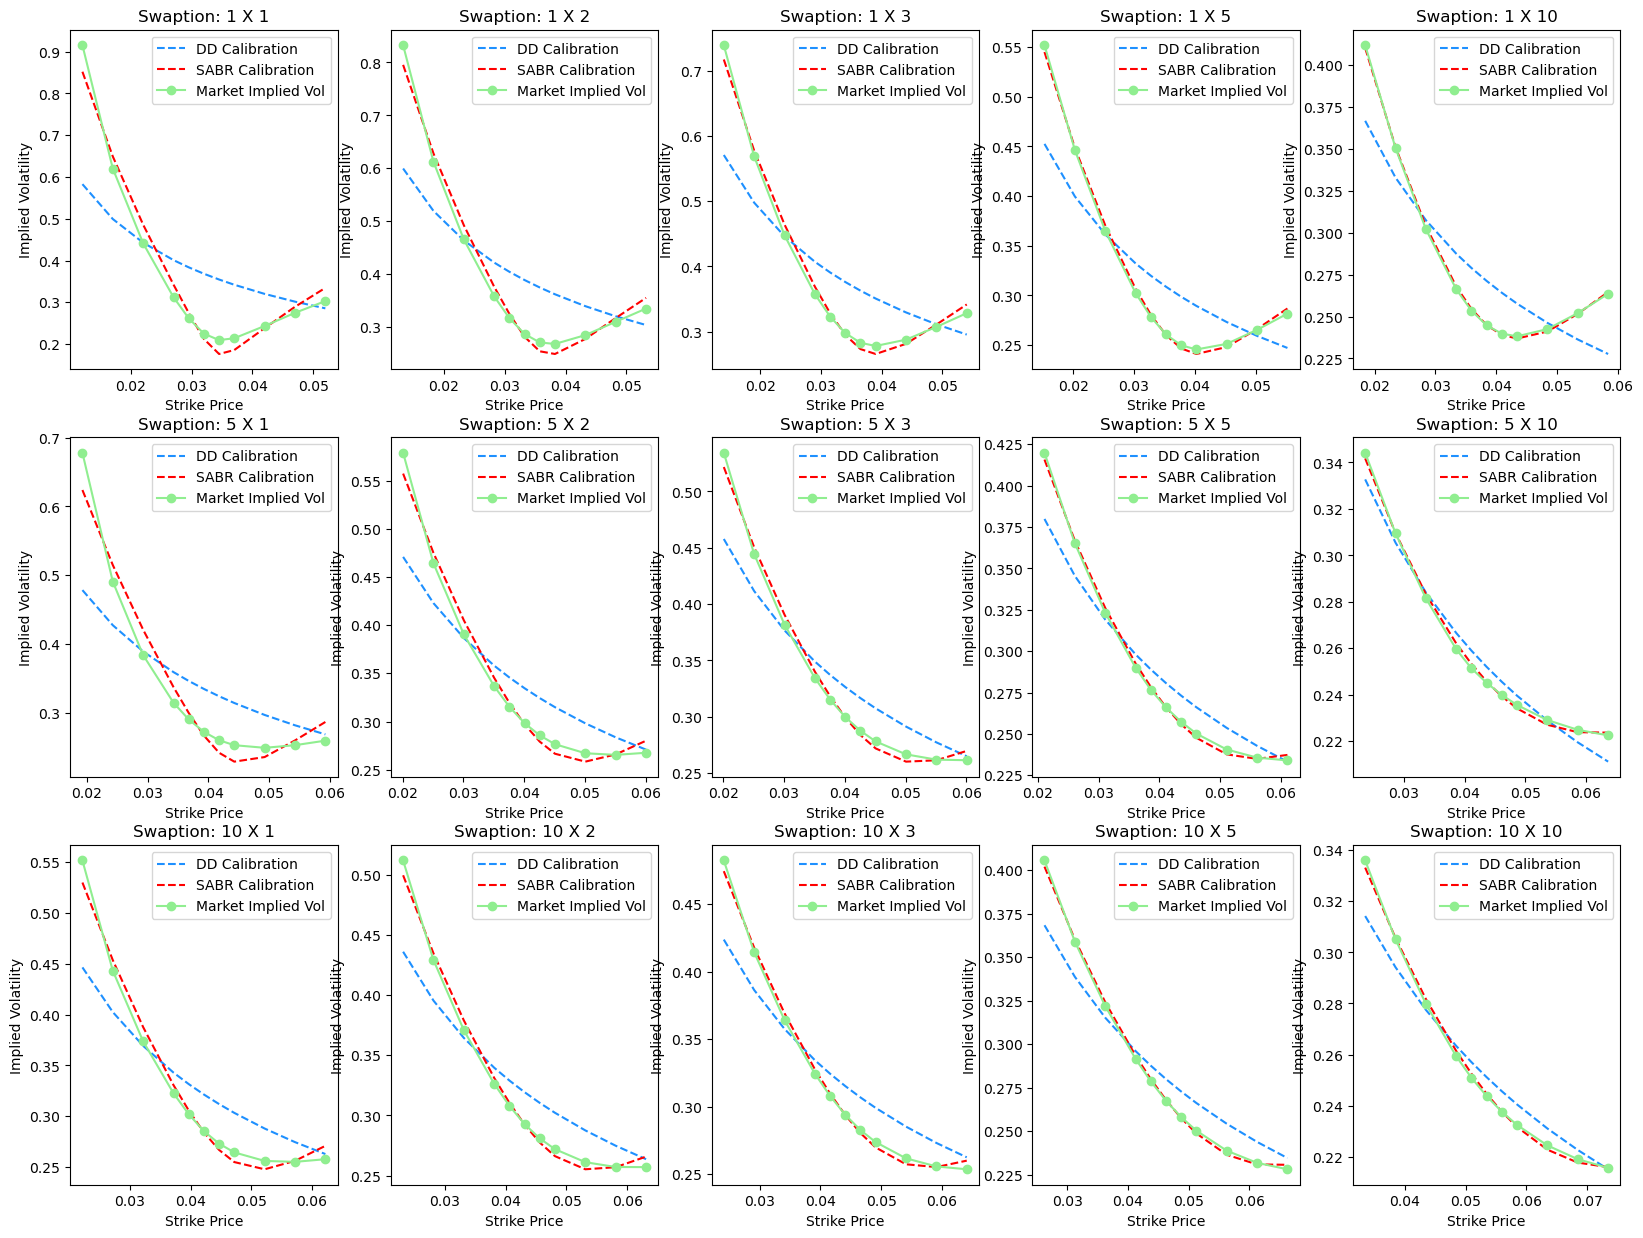

In [563]:
def sabr_dd_implied_vol_plot(x):
    plt.plot(strike_df.iloc[x, 2:13], dd_calib_data.iloc[x, 2:13], linestyle ='--', color='dodgerblue', label='DD Calibration')
    plt.plot(strike_df.iloc[x, 2:13], sabr_calib_data.iloc[x, 2:13], linestyle ='--', color='red', label='SABR Calibration')
    plt.plot(strike_df.iloc[x, 2:13], swaption_data.iloc[x, 2:13], marker='o', color='lightgreen', label='Market Implied Vol')
    plt.title(f"Swaption: {swaption_data.loc[x, 'Expiry']} X {swaption_data.loc[x, 'Tenor']}")
    plt.legend()
    plt.ylabel("Implied Volatility")
    plt.xlabel("Strike Price")

plt.figure(figsize=(20, 15))
for i in range(len(swaption_data)):
    plt.subplot(3,5,i+1)
    sabr_dd_implied_vol_plot(i)

### Part 4: Swaption Pricing 

In [389]:
swaption_params = pd.DataFrame({'Expiry': swaption_data[swaption_data['Tenor']==10]['Expiry'],
                                'Tenor': swaption_data[swaption_data['Tenor']==10]['Tenor'],
                                'Sigma': dd_calib_data[dd_calib_data['Tenor']==10]['Sigma'],
                                'Beta': dd_calib_data[dd_calib_data['Tenor']==10]['Beta'],
                                'Alpha': sabr_calib_data[sabr_calib_data['Tenor']==10]['Alpha'],
                                'Rho': sabr_calib_data[sabr_calib_data['Tenor']==10]['Rho'],
                                'Nu': sabr_calib_data[sabr_calib_data['Tenor']==10]['Nu'],
                               'Forward Rate': sabr_model_df[sabr_model_df['Tenor']==10]['Forward Rate']})
swaption_params

,Expiry,Tenor,Sigma,Beta,Alpha,Rho,Nu,Forward Rate
4,1,10,0.270408,0.169994,0.170838,-0.264029,0.781910,0.038428
9,5,10,0.248736,0.097253,0.177208,-0.438680,0.495769,0.043634
14,10,10,0.244710,0.080941,0.180771,-0.510189,0.578658,0.053458


In [417]:
# Use Interpolation function
def interpolate(x1, x2, tenor, name, x):
    y1 = swaption_params[(swaption_params['Expiry'] == x1) & (swaption_params['Tenor'] == tenor)][name].values[0]
    y2 = swaption_params[(swaption_params['Expiry'] == x2) & (swaption_params['Tenor'] == tenor)][name].values[0]
    return y1 + (x - x1) * ((y2 - y1) / (x2 - x1))

#### 4a: Case 1 - 2x10 Payer Swaption

In [492]:
# Step 1: Calculate the forward swap rate
expiry_range = [1, 2, 5, 8, 10]
tenor_range = [1, 2, 3, 5, 10]

forward_rate_new = []
for i in expiry_range:
    for j in tenor_range:

        # Fixed leg
        discounting = 0.5 * sum(discount_rate['OIS_DF'][i * 2: 2 * (i+j)])

        # Floating leg
        float = []
        for step in range(i * 2, 2 * (i+j)):
            numerator = discount_rate['OIS_DF'][step] * (discount_rate['LIBOR_DF'][step-1]-
                                                         discount_rate['LIBOR_DF'][step]) / discount_rate['LIBOR_DF'][step]
            float.append(numerator)
            
        num_value = sum(float)
        forward_rate_new.append([f'{i}', f'{j}', num_value / discounting])
        
forward_rate_new_df = pd.DataFrame(forward_rate_new, columns=['Expiry', 'Tenor', 'Forward Rate'])
forward_rate_new_df['Expiry'] = forward_rate_new_df['Expiry'].astype(int)
forward_rate_new_df['Tenor'] = forward_rate_new_df['Tenor'].astype(int)
forward_rate_new_df

,Expiry,Tenor,Forward Rate
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038428
5,2,1,0.034516
6,2,2,0.035018
7,2,3,0.035018
8,2,5,0.037027
9,2,10,0.039634


In [460]:
# Step 2: Calculate the new PVBP 
def pvbp_value(start, end):
    id_start = discount_rate[discount_rate["Tenor"] == start + 0.5].index[0]
    id_end = discount_rate[discount_rate["Tenor"] == end].index[0]
    df_slice = discount_rate['OIS_DF'].iloc[id_start:id_end]
    return(sum(0.5 * df_slice))

In [462]:
# Step 3: Using interpolation to define the DD and SABR parameters under given expiry and tenor
strikes = np.arange(0.01, 0.081, 0.01) # K= 1%~8%
expiry1, expiry2, expiry3, tenor1 = 1, 2, 5, 10  

dd_sigma_2_10 = interpolate(expiry1, expiry3, tenor1, 'Sigma', expiry2)
dd_beta_2_10 = interpolate(expiry1, expiry3, tenor1, 'Beta', expiry2)
sabr_alpha_2_10 = interpolate(expiry1, expiry3, tenor1, 'Alpha', expiry2)
sabr_rho_2_10 = interpolate(expiry1, expiry3, tenor1, 'Rho', expiry2)
sabr_nu_2_10 = interpolate(expiry1, expiry3, tenor1, 'Nu', expiry2)

print('Displaced Diffusion Interpolate Params')
print(f'Sigma: {dd_sigma_2_10}'); print(f'Beta: {dd_beta_2_10}') 
print('\nSABR Interpolate Params')
print(f'Alpha: {sabr_alpha_2_10}'); print(f'Rho: {sabr_rho_2_10}'); print(f'Nu: {sabr_nu_2_10}')

Displaced Diffusion Interpolate Params
Sigma: 0.26499033404212224
Beta: 0.1518088588801247

SABR Interpolate Params
Alpha: 0.17243028413723038
Rho: -0.3076916784362261
Nu: 0.7103746882849068


In [502]:
# Step 4: Calculate the DD and SABR pricing of payer swaption

expiry_case1 = 2
tenor_case1 = 10
fsr_2_10 = forward_rate_new_df['Forward Rate'][(forward_rate_new_df['Expiry'] == expiry_case1) & (forward_rate_new_df['Tenor'] == tenor_case1)].values[0]
pvbp_2_10 = pvbp_value(expiry_case1, expiry_case1 + tenor_case1)

dd_payer_2_10_price = []
sabr_payer_2_10_price = []

for s in strikes:
    #DD
    dd_payer_2_10 = DisplacedDiffusionPayer(fsr_2_10, s, expiry_case1, pvbp_2_10, dd_sigma_2_10, dd_beta_2_10)
    dd_payer_2_10_price.append(dd_payer_2_10)

    #SABR
    sabr_sigma_2_10 = SABR(fsr_2_10, s, expiry_case1, sabr_alpha_2_10, 0.9, sabr_rho_2_10, sabr_nu_2_10)
    sabr_payer_2_10 = Black76Call(fsr_2_10, s, sabr_sigma_2_10, expiry_case1, pvbp_2_10)
    sabr_payer_2_10_price.append(sabr_payer_2_10)

payer_2_10_df = pd.DataFrame({
    'Strike': strikes,
    'DD Price': dd_payer_2_10_price,
    'SABR Price': sabr_payer_2_10_price
})

payer_2_10_df

,Strike,DD Price,SABR Price
0,0.01,0.274237,0.275528
1,0.02,0.186283,0.188691
2,0.03,0.109416,0.109602
3,0.04,0.053037,0.049598
4,0.05,0.020496,0.020332
5,0.06,0.006202,0.010243
6,0.07,0.001464,0.006334
7,0.08,0.000271,0.004451


#### 4b: Case 2 - 8x10 Receiver Swaption

In [507]:
# Step 1: Using interpolation to define the DD and SABR parameters under given expiry and tenor
strikes = np.arange(0.01, 0.081, 0.01) # K= 1%~8%
expiry3, expiry4, expiry5, tenor2 = 5, 8, 10, 10  

dd_sigma_8_10 = interpolate(expiry3, expiry5, tenor2, 'Sigma', expiry4)
dd_beta_8_10 = interpolate(expiry3, expiry5, tenor2, 'Beta', expiry4)
sabr_alpha_8_10 = interpolate(expiry3, expiry5, tenor2, 'Alpha', expiry4)
sabr_rho_8_10 = interpolate(expiry3, expiry5, tenor2, 'Rho', expiry4)
sabr_nu_8_10 = interpolate(expiry3, expiry5, tenor2, 'Nu', expiry4)

print('Displaced Diffusion Interpolate Params')
print(f'Sigma: {dd_sigma_8_10}'); print(f'Beta: {dd_beta_8_10}') 
print('\nSABR Interpolate Params')
print(f'Alpha: {sabr_alpha_8_10}'); print(f'Rho: {sabr_rho_8_10}'); print(f'Nu: {sabr_nu_8_10}')

Displaced Diffusion Interpolate Params
Sigma: 0.2463206071375913
Beta: 0.08746555959376592

SABR Interpolate Params
Alpha: 0.17934557835964243
Rho: -0.48158536464785373
Nu: 0.5455021634151254


In [511]:
# Step 2: Calculate the DD and SABR pricing of payer swaption

expiry_case2 = 8
tenor_case2 = 10
fsr_8_10 = forward_rate_new_df['Forward Rate'][(forward_rate_new_df['Expiry'] == expiry_case1) & (forward_rate_new_df['Tenor'] == tenor_case1)].values[0]
pvbp_8_10 = pvbp_value(expiry_case2, expiry_case2 + tenor_case2)

dd_receiver_8_10_price = []
sabr_receiver_8_10_price = []

for s in strikes:
    #DD
    dd_receiver_8_10 = DisplacedDiffusionReceiver(fsr_8_10, s, expiry_case2, pvbp_8_10, dd_sigma_8_10, dd_beta_8_10)
    dd_receiver_8_10_price.append(dd_receiver_8_10)

    #SABR
    sabr_sigma_8_10 = SABR(fsr_8_10, s, expiry_case2, sabr_alpha_8_10, 0.9, sabr_rho_8_10, sabr_nu_8_10)
    sabr_receiver_8_10 = Black76Put(fsr_8_10, s, sabr_sigma_8_10, expiry_case2, pvbp_8_10)
    sabr_receiver_8_10_price.append(sabr_receiver_8_10)

receiver_8_10_df = pd.DataFrame({
    'Strike': strikes,
    'DD Price': dd_receiver_8_10_price,
    'SABR Price': sabr_receiver_8_10_price
})

receiver_8_10_df

,Strike,DD Price,SABR Price
0,0.01,0.016018,0.018583
1,0.02,0.032873,0.038221
2,0.03,0.060218,0.063442
3,0.04,0.099932,0.099578
4,0.05,0.152375,0.153132
5,0.06,0.216349,0.223481
6,0.07,0.289593,0.303232
7,0.08,0.369494,0.387224


### Part 5: Final Result

#### 5a: Displaced Diffusion Calibrated Parameter

In [521]:
print('Displaced Diffusion Model Calibrated Sigma')
display(dd_sigma)
print('Displaced Diffusion Model Calibrated Beta')
display(dd_beta)

Displaced Diffusion Model Calibrated Sigma


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.366383,0.386641,0.373880,0.307546,0.270408
5,0.327257,0.326885,0.319352,0.276239,0.248736
10,0.308141,0.306315,0.302794,0.271029,0.244710


Displaced Diffusion Model Calibrated Beta


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.000234,0.002127,0.004175,0.041992,0.169994
5,0.006103,0.024384,0.033407,0.103428,0.097253
10,0.055658,0.080290,0.100007,0.082890,0.080941


#### 5b: SABR Calibrated Parameter

In [528]:
print('SABR Calibrated Alpha')
display(sabr_alpha)
print('SABR Calibrated Rho')
display(sabr_rho)
print('SABR Calibrated Nu')
display(sabr_nu)

SABR Calibrated Alpha


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.139072,0.184649,0.196851,0.178052,0.170838
5,0.166544,0.199505,0.210357,0.190780,0.177208
10,0.177487,0.195232,0.206481,0.201494,0.180771


SABR Calibrated Rho


Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.633217,-0.525116,-0.482845,-0.414426,-0.264029
5,-0.585317,-0.546907,-0.549817,-0.509843,-0.438680
10,-0.545617,-0.544287,-0.549047,-0.562481,-0.510189


SABR Calibrated Nu


Tenor,1,2,3,5,10
Expiry,,,,,
1,2.049453,1.677405,1.438139,1.064877,0.781910
5,1.339876,1.061933,0.936737,0.672606,0.495769
10,1.006947,0.925336,0.867521,0.720021,0.578658


#### 5c: Payer 2x10y Swaption Pricing

In [545]:
print('The Price of Payer Swaption 2 x 10Y')
display(payer_2_10_df)

The Price of Payer Swaption 2 x 10Y


,Strike,DD Price,SABR Price
0,0.01,0.274237,0.275528
1,0.02,0.186283,0.188691
2,0.03,0.109416,0.109602
3,0.04,0.053037,0.049598
4,0.05,0.020496,0.020332
5,0.06,0.006202,0.010243
6,0.07,0.001464,0.006334
7,0.08,0.000271,0.004451


#### 5d: Receiver 8x10y Swaption Pricing

In [547]:
print('The Price of Receiver Swaption 8 x 10Y')
receiver_8_10_df 

The Price of Receiver Swaption 8 x 10Y


,Strike,DD Price,SABR Price
0,0.01,0.016018,0.018583
1,0.02,0.032873,0.038221
2,0.03,0.060218,0.063442
3,0.04,0.099932,0.099578
4,0.05,0.152375,0.153132
5,0.06,0.216349,0.223481
6,0.07,0.289593,0.303232
7,0.08,0.369494,0.387224
